In [51]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pylab as plt
import config as cf

from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from chinese_calendar import is_workday, is_holiday
from jupyterthemes import jtplot

jtplot.style()
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200

In [52]:
train_df = pd.read_csv(cf.train_file_path, sep='\t')
test_df = pd.read_csv(cf.testA_file_path, sep='\t')

In [53]:
def fix_data_date(df, last_dow, start_date):
    fix_rows = []
    fix_date = 0
    fix_columns = np.append(df.columns.values, 'date_fix')
    is_train = 'cnt' in fix_columns
    for i, row in df.iterrows():
        curr_dow = row['day_of_week']
        while curr_dow - last_dow > 1 or -6 < curr_dow - last_dow <= 0:
            last_dow = last_dow + 1 if last_dow < 7 else 1
            fix_date += 1
            if is_train:
                fix_rows.append(np.array([-1, 0, last_dow, start_date + timedelta(days=fix_date)]))
            else:
                fix_rows.append(np.array([-1, last_dow, start_date + timedelta(days=fix_date)]))
        last_dow = curr_dow
        fix_date += 1
        fix_rows.append(np.append(row.values, start_date + timedelta(days=fix_date)))
    new_df = pd.DataFrame(fix_rows, columns=fix_columns)
    return new_df

# process train date
start_train_date = datetime(2013,1,1)
train_cnt_df = train_df.groupby('date', as_index=False)['cnt'].sum()
train_cnt_df = train_cnt_df.merge(train_df[['date', 'day_of_week']].drop_duplicates(), on='date')
train_new_df = fix_data_date(train_cnt_df, 2, start_train_date)
# process test date
start_test_date = train_new_df.iloc[-1,-1] - timedelta(days=1)
last_dow = train_new_df.iloc[-1,-2] - 1
test_new_df = fix_data_date(test_df, last_dow, start_test_date)

##### 1. devide raw data into month trend and daily factor.

In [54]:
# process train data
train_new_df['month'] = train_new_df['date_fix'].map(lambda x:datetime(x.year,x.month,1))
train_fix_df = train_new_df.loc[train_new_df['month'] < '20160401']
train_fix_df.to_csv(cf.train_fix_file_path)
frame_sum = train_fix_df.groupby('month')['cnt'].sum()
frame_sum.name = 'month_sum'
frame_days = train_fix_df.loc[train_fix_df['date']>0].groupby('month')['date'].count()
frame_days.name = 'month_days'
frame_mean = frame_sum / frame_days
frame_mean.name = 'month_mean'
train_fix_df = train_fix_df.merge(frame_sum.reset_index(), on='month')
train_fix_df = train_fix_df.merge(frame_days.reset_index(), on='month')
train_fix_df = train_fix_df.merge(frame_mean.reset_index(), on='month')
train_fix_df.set_index('date_fix', inplace=True)
# process test data
test_new_df['month'] = test_new_df['date_fix'].map(lambda x:datetime(x.year,x.month,1))
test_fix_df = test_new_df
test_fix_df.to_csv(cf.test_fix_file_path)
frame_days = test_fix_df.loc[test_fix_df['date']>0].groupby('month')['date'].count()
frame_days.name = 'month_days'
# fix last day
frame_days[-1] = 21
test_fix_df = test_fix_df.merge(frame_days.reset_index(), on='month')
test_fix_df.set_index('date_fix', inplace=True)

##### 2. First Predict monthly trend

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


(-3.8102712410984028, 0.0028039577651400578, 1, 24, {'5%': -2.9922162731481485, '1%': -3.7377092158564813, '10%': -2.6357467361111109}, 12.942695517715769)
                              ARMA Model Results                              
Dep. Variable:             month_mean   No. Observations:                   26
Model:                     ARMA(1, 1)   Log Likelihood                 -12.162
Method:                       css-mle   S.D. of innovations              0.375
Date:                Wed, 24 Jan 2018   AIC                             32.325
Time:                        09:47:26   BIC                             37.357
Sample:                    01-01-2014   HQIC                            33.774
                         - 03-01-2016                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.5725      0.085    

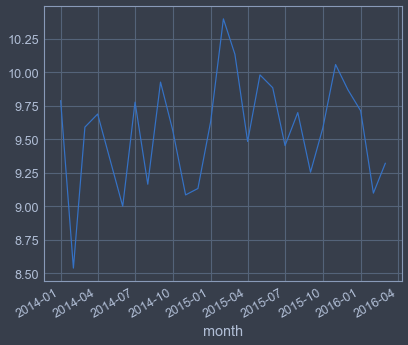

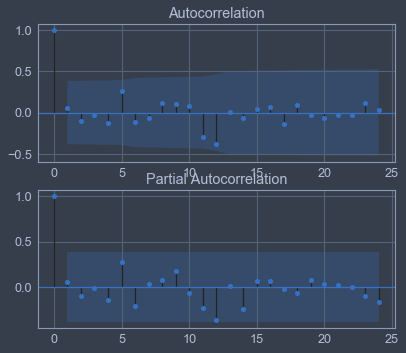

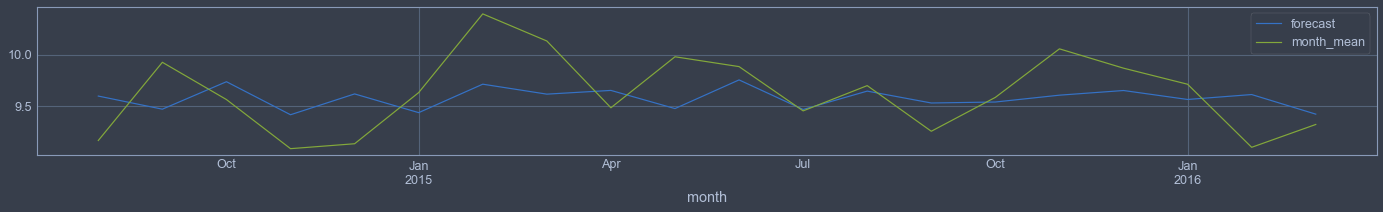

In [87]:
ts = frame_sum.diff(12)
# deal with neg values and use log to reduce amplitude
ts = np.log(ts+10000)
ts.dropna(inplace=True)
# fix sample with huge diff
ts[4] = 9.
ts.plot()

f = plt.figure()
ax1 = f.add_subplot(211)
plot_acf(ts, lags=24, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(ts, lags=24, ax=ax2)

print adfuller(ts)
f = plt.figure(figsize=(24,6))
ax1 = f.add_subplot(211)
#ax2 = f.add_subplot(212)
model = ARMA(ts, order=(3, 3)) 
result_arma = model.fit(disp=-1)
result_arma.plot_predict(start='2014-08-01', ax=ax1)
print result_arma.summary()

In [85]:
# recover predict value
predict_values = result_arma.predict(end='2017-12-1')
# log recover
predict_values = np.exp(predict_values) - 10000

predict_values.plot()
frame_sum.diff(12).plot()


frame_sum_ext = frame_sum.append(pd.Series(index=pd.date_range('2016-04','2017-03',freq='MS')))
# calculate feature 2 years month brand value.
pred_ts = (frame_sum_ext.shift(12) + predict_values).dropna()

pred_ts_ext = pred_ts.append(pd.Series(index=pd.date_range('2017-04','2017-12',freq='MS'))).shift(12)[-12:] + predict_values
pred_ts = pred_ts.append(pred_ts_ext[-9:])

frame_sum_ext.plot()
pred_ts.plot()

ValueError: Must provide freq argument if no data is supplied

##### 2. predict daily factor.

In [57]:
import xgboost

In [58]:
def process_features(df):
    # add month infos.
    df.loc[:,'month_of_year'] = df.index.map(lambda x: x.month)
    df.loc[:,'day_of_month'] = df.index.map(lambda x: 1 if x.day < 11 else 2 if x.day < 21 else 3)
    # add holiday infos.
    df.loc[:,'is_holiday'] = df.index.map(lambda x: 1 if is_holiday(x.date()) else 0)
    df.loc[:,'is_day_off'] = df[['is_holiday','day_of_week']].apply(lambda x: 1 if not x[0] and x[1] > 5 else 0, axis=1)
    df.loc[:,'after_holiday'] = 0
    df.loc[:,'before_holiday'] = 0
    df.loc[:,'after_holiday_1'] = 0
    df.loc[:,'before_holiday_1'] = 0
    df.loc[:,'after_holiday_2'] = 0
    df.loc[:,'before_holiday_2'] = 0
    last_holidays = 0
    for index, row in df.iterrows():
        if row['is_holiday']:
            last_holidays += 1
        else:
            # law holiday
            if last_holidays > 2:
                holiday_long = 1 if last_holidays > 3 else 0.5
                df.loc[index, 'after_holiday'] = holiday_long
                before_index = index - timedelta(days=last_holidays + 1)
                if before_index in df.index:
                    df.loc[before_index, 'before_holiday'] = holiday_long
                i = 1
                after_ext_index = index + timedelta(days=1)
                while i < 3 and after_ext_index in df.index:
                    if df.loc[after_ext_index, 'is_holiday']:
                        after_ext_index = after_ext_index + timedelta(days=1)
                        continue
                    df.loc[after_ext_index, 'after_holiday_%d' % i] = holiday_long
                    i += 1
                    after_ext_index = after_ext_index + timedelta(days=1)
                i = 1
                before_ext_index = before_index - timedelta(days=1)
                while i < 3 and before_ext_index in df.index:
                    if df.loc[before_ext_index, 'is_holiday']:
                        before_ext_index = before_ext_index - timedelta(days=1)
                        continue
                    df.loc[before_ext_index, 'before_holiday_%d' % i] = holiday_long
                    i += 1
                    before_ext_index = before_ext_index - timedelta(days=1)
            last_holidays = 0
    # day before holiday or after holiday infos
    df = df.join(pd.get_dummies(df['day_of_week'], prefix='day_of_week'))
    df = df.join(pd.get_dummies(df['day_of_month'], prefix='day_of_month'))
    df = df.join(pd.get_dummies(df['month_of_year'], prefix='month_of_year'))
    return df



train_proc_df = process_features(train_fix_df)
test_proc_df = process_features(test_fix_df)
# labels
train_proc_df.loc[:,'day_factor'] = train_proc_df['cnt'] / train_proc_df['month_mean']

# 取出训练集的y
train_y = train_proc_df.iloc[:,-1]
train_X = train_proc_df.iloc[:,9:-1]
test_X = test_proc_df.iloc[:,6:]
train_X = train_X.drop('month_of_year_3', 1)

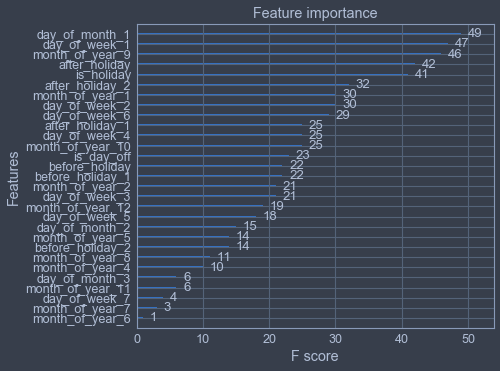

In [59]:
# 建立一个默认的xgboost回归模型
reg = xgboost.XGBRegressor()
reg.fit(train_X, train_y)
xgboost.plot_importance(reg)

In [60]:
# 预测
y_pred = reg.predict(test_X)
frame = pd.Series(y_pred, index=test_X.index)
frame.map(lambda x:x if x > 0 else 0)
frame.name = 'pred'
#pred_df = test_X.join(pred_y)
pred_df = test_fix_df.join(frame)

In [61]:
# 预测结果组合
frame = pred_ts
frame.name = 'month_sum'
pred_cb_df = pred_df.join(frame, on='month')
pred_cb_df.loc[:, 'month_mean'] = pred_cb_df['month_sum'] / pred_cb_df['month_days']
pred_cb_df.loc[:, 'predict'] = pred_cb_df['month_mean'] * pred_cb_df['pred']
pred_cb_df.loc[:, 'predict'] = pred_cb_df['predict'].map(lambda x:x if x > 0 else 0)

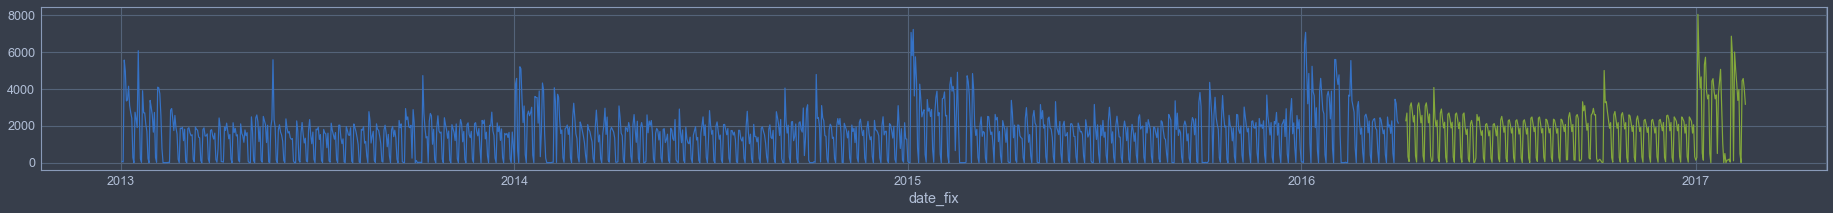

In [72]:
train_fix_df['cnt'].plot(figsize=(32,3))
pred_cb_df['predict'].plot(figsize=(32,3))
pred_cb_df.loc[pred_cb_df['date']>0][['date', 'predict']].astype(int).to_csv('test.csv', sep='\t', index=False, header=False)

In [73]:
pred_cb_df[['date', 'day_of_week', 'predict']].to_csv('test_fix.csv')
print pred_cb_df.groupby('month').sum()['pred']
print pred_cb_df[['month', 'month_days']].drop_duplicates()

month
2016-04-01    20.839193
2016-05-01    26.924086
2016-06-01    27.050241
2016-07-01    25.980513
2016-08-01    29.738707
2016-09-01    25.883249
2016-10-01    24.790865
2016-11-01    27.707031
2016-12-01    26.454985
2017-01-01    24.409149
2017-02-01    15.413146
Name: pred, dtype: float32
                month  month_days
date_fix                         
2016-04-07 2016-04-01          21
2016-05-01 2016-05-01          25
2016-06-01 2016-06-01          27
2016-07-01 2016-07-01          26
2016-08-01 2016-08-01          28
2016-09-01 2016-09-01          27
2016-10-01 2016-10-01          26
2016-11-01 2016-11-01          29
2016-12-01 2016-12-01          28
2017-01-01 2017-01-01          25
2017-02-01 2017-02-01          21
